# 1. Setup

## 1.1 Install Dependencies

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os 
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [5]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ec7fc5a3-f0a0-11ec-a99d-74e6e24c3a72.jpg'

In [87]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

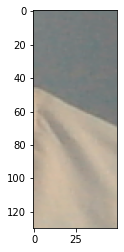

In [100]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [177]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [178]:
import os
import uuid

In [179]:
img_path = os.path.join(ANC_PATH, '1f2ee6bd-e18c-11ec-b9ee-74e6e24c3a72.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [180]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [181]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [182]:
dir_test = anchor.as_numpy_iterator()

In [183]:
print(dir_test.next())

b'data\\anchor\\d746cadc-e4b1-11ec-b437-74e6e24c3a72.jpg'


## 3.2 Preprocessing - Scale and Resize

In [184]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [185]:
img = preprocess('data\\anchor\\29530f7f-eee8-11ec-8024-74e6e24c3a72.jpg')

In [186]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

In [187]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [188]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [189]:
samples = data.as_numpy_iterator()

In [190]:
exampple = samples.next()

In [191]:
exampple

(b'data\\anchor\\cf812e31-e71b-11ec-94d1-74e6e24c3a72.jpg',
 b'data\\positive\\3001da7b-f24a-11ec-86a1-74e6e24c3a72.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [192]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [193]:
res = preprocess_twin(*exampple)

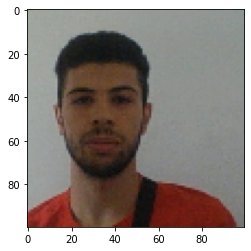

In [194]:
plt.imshow(res[0])

In [195]:
res[2]

1.0

In [196]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [197]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [198]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [199]:
inp = Input(shape=(100,100,3), name='input_image')

In [200]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [201]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [202]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [203]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [204]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [205]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [206]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

In [207]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [208]:
embedding = make_embedding()

In [209]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [210]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [211]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [212]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [213]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [214]:
siamese_layer = L1Dist()

In [215]:
distances = siamese_layer(inp_embedding, val_embedding)

In [216]:
classifier = Dense(1, activation='sigmoid')(distances)

In [217]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_10')>

In [218]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [219]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [220]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [221]:
siamese_model = make_siamese_model()

In [222]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [223]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [224]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [225]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [226]:
test_batch = train_data.as_numpy_iterator()

In [227]:
batch_1 = test_batch.next()

In [228]:
X = batch_1[:2]

In [229]:
y = batch_1[2]

In [230]:
y

array([0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [231]:
tf.losses.BinaryCrossentropy??

In [232]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [233]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [234]:
plot_loss = []
plot_recall = []
plot_precision = []

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        plot_loss.append(loss.numpy())
        plot_recall.append(r.result().numpy())
        plot_precision.append(p.result().numpy())
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [235]:
EPOCHS = 20

In [236]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
48/48 [==============================] - 2834s 58s/step
0.5681476 0.2540107 0.7364341

 Epoch 2/20
48/48 [==============================] - 2777s 58s/step
0.6429183 0.5801527 0.7549669

 Epoch 3/20
48/48 [==============================] - 2773s 58s/step
0.73354167 0.68393785 0.7810651

 Epoch 4/20
48/48 [==============================] - 2779s 58s/step
0.60524327 0.76329786 0.79501384

 Epoch 5/20
48/48 [==============================] - 2774s 58s/step
0.47306475 0.7070707 0.7407407

 Epoch 6/20
48/48 [==============================] - 2684s 56s/step
0.40584603 0.7241379 0.8005865

 Epoch 7/20
48/48 [==============================] - 2606s 54s/step
0.3128706 0.78851175 0.80748665

 Epoch 8/20
48/48 [==============================] - 2603s 54s/step
0.16917245 0.7591623 0.83094555

 Epoch 9/20
48/48 [=======================

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.5681476, 0.6429183, 0.73354167, 0.60524327, 0.47306475, 0.40584603, 0.3128706, 0.16917245, 0.2606938, 0.19812888, 0.25877675, 0.36632657, 0.21670358, 0.31556296, 0.43577203, 0.26078364, 0.41077366, 0.21319048, 0.11992216, 0.065105826]


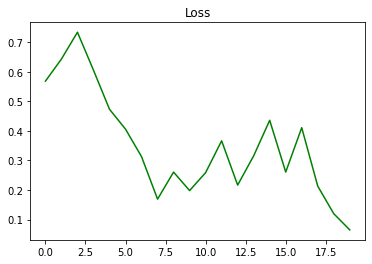

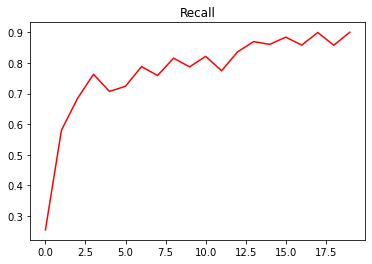

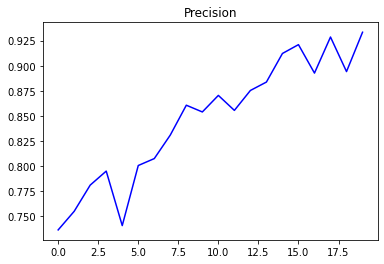

In [237]:
import matplotlib.pyplot as plt


x = [*range(0, len(plot_loss))]

print(x)
print(plot_loss)
 

plt.plot(x, plot_loss, color='green')
plt.title('Loss')
plt.show()

plt.plot(x, plot_recall, color='red', label="X")
plt.title('Recall')
plt.show()

plt.plot(x, plot_precision, color='blue')
plt.title('Precision')
plt.show()
  
# function to show the plot


In [149]:
print(classification_report(real_labels_names,predicted_labels_names,labels=Classes_names))

NameError: name 'classification_report' is not defined

# 6. Evaluate Model

## 6.1 Import Metrics

In [238]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [239]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [240]:
y_hat = siamese_model.predict([test_input, test_val])

In [241]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]

In [242]:
y_true

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [243]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.6666667

In [244]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [245]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.90361446 0.9375


## 6.4 Viz Results

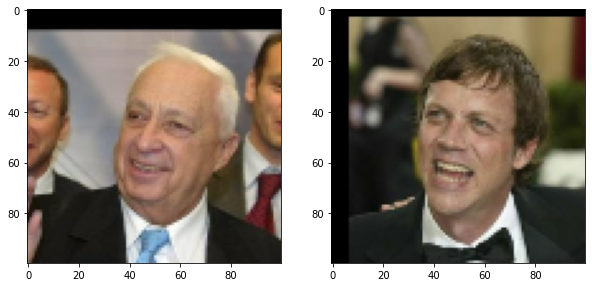

In [246]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [247]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [248]:
L1Dist

__main__.L1Dist

In [249]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [250]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.31302   ],
       [0.9991714 ],
       [0.9888375 ],
       [0.0773786 ],
       [0.01776841],
       [0.9969443 ],
       [0.04869637],
       [0.14339387]], dtype=float32)

In [251]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [252]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0a834ee5-e0c4-11ec-a37d-74e6e24c3a72.jpg',
 '0ab7f16a-e0c4-11ec-9bd5-74e6e24c3a72.jpg',
 '2be3f601-e18c-11ec-96f0-74e6e24c3a72.jpg',
 '2c9d4d15-e18c-11ec-ba64-74e6e24c3a72.jpg',
 '2e9980dd-e18c-11ec-a555-74e6e24c3a72.jpg',
 '30ecf569-e18c-11ec-a867-74e6e24c3a72.jpg',
 '3214960b-e0c2-11ec-93cf-74e6e24c3a72.jpg',
 '330fef36-e0c2-11ec-acbd-74e6e24c3a72.jpg',
 '3372508f-e0c2-11ec-b581-74e6e24c3a72.jpg',
 '3415ec49-e0c2-11ec-a6f3-74e6e24c3a72.jpg',
 '46e40d0e-e0c7-11ec-8c2e-74e6e24c3a72.jpg',
 '486ee787-e0c7-11ec-84b7-74e6e24c3a72.jpg',
 '4997e0d1-e0c7-11ec-b740-74e6e24c3a72.jpg',
 '5a23c1eb-e0c3-11ec-8f7f-74e6e24c3a72.jpg',
 '5ae8cd90-e0c3-11ec-8bec-74e6e24c3a72.jpg',
 '5cb90567-e0c3-11ec-9448-74e6e24c3a72.jpg',
 '5dcde7c8-e0c3-11ec-90c3-74e6e24c3a72.jpg',
 '65c40082-e0c3-11ec-ae89-74e6e24c3a72.jpg',
 '65ec9747-e0c3-11ec-9341-74e6e24c3a72.jpg',
 '75aceeeb-e0c5-11ec-8d27-74e6e24c3a72.jpg',
 '7a496b3a-e0c6-11ec-94e2-74e6e24c3a72.jpg',
 '7a64376a-e0c6-11ec-843e-74e6e24c3a72.jpg',
 '90c18d64

In [253]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [254]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0a834ee5-e0c4-11ec-a37d-74e6e24c3a72.jpg
application_data\verification_images\0ab7f16a-e0c4-11ec-9bd5-74e6e24c3a72.jpg
application_data\verification_images\2be3f601-e18c-11ec-96f0-74e6e24c3a72.jpg
application_data\verification_images\2c9d4d15-e18c-11ec-ba64-74e6e24c3a72.jpg
application_data\verification_images\2e9980dd-e18c-11ec-a555-74e6e24c3a72.jpg
application_data\verification_images\30ecf569-e18c-11ec-a867-74e6e24c3a72.jpg
application_data\verification_images\3214960b-e0c2-11ec-93cf-74e6e24c3a72.jpg
application_data\verification_images\330fef36-e0c2-11ec-acbd-74e6e24c3a72.jpg
application_data\verification_images\3372508f-e0c2-11ec-b581-74e6e24c3a72.jpg
application_data\verification_images\3415ec49-e0c2-11ec-a6f3-74e6e24c3a72.jpg
application_data\verification_images\46e40d0e-e0c7-11ec-8c2e-74e6e24c3a72.jpg
application_data\verification_images\486ee787-e0c7-11ec-84b7-74e6e24c3a72.jpg
application_data\verification_images\4997e0d1-e0c7-11ec-b740-74e

In [255]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    #verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verification = detection / len(results) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [257]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_imagefolder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True


In [92]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False


In [93]:
np.sum(np.squeeze(results) > 0.5)

3

In [94]:
results

[array([[0.49970302]], dtype=float32),
 array([[0.49340892]], dtype=float32),
 array([[0.49644637]], dtype=float32),
 array([[0.49618554]], dtype=float32),
 array([[0.5007367]], dtype=float32),
 array([[0.49847364]], dtype=float32),
 array([[0.4915573]], dtype=float32),
 array([[0.4925423]], dtype=float32),
 array([[0.49149403]], dtype=float32),
 array([[0.48986343]], dtype=float32),
 array([[0.4989664]], dtype=float32),
 array([[0.49904695]], dtype=float32),
 array([[0.49906734]], dtype=float32),
 array([[0.49733862]], dtype=float32),
 array([[0.49596822]], dtype=float32),
 array([[0.49728438]], dtype=float32),
 array([[0.49846193]], dtype=float32),
 array([[0.49210367]], dtype=float32),
 array([[0.49212307]], dtype=float32),
 array([[0.49708343]], dtype=float32),
 array([[0.49141806]], dtype=float32),
 array([[0.49111676]], dtype=float32),
 array([[0.49938947]], dtype=float32),
 array([[0.4969944]], dtype=float32),
 array([[0.50064373]], dtype=float32),
 array([[0.50004816]], dtype=f